In [2]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
import torch
import numpy as np
import functools
from torch import nn
from torch.autograd import Variable
import scipy.sparse as sparse
from sklearn.metrics import mean_squared_error
from functools import partial
import torch.nn.functional as F
import torch.optim as optim
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler
from torch.utils.data import random_split
import dill
# dill.load_session('notebook_env.db')

In [3]:
import scipy.io
import matplotlib.pyplot as plt

def hadamard(A, B):
    # *
    return np.multiply(A, B)


def khatri_rao(A, B):
    # circle dot
    I = A.shape[0]
    J = A.shape[1]
    K = B.shape[0]
    L = B.shape[1]
    result = np.zeros((I*J, K))
    column_stack = []
    for l in np.arange(L):
        result = kronecker(A[:, l].T.reshape(I, 1), B[:, l].reshape(K, 1))
        column_stack.append(result)
    return np.column_stack(column_stack)


def kronecker(A, B):
    # ⊗
    I = A.shape[0]
    if len(A.shape) == 1:
        J = 1
    else:
        J = A.shape[1]
    K = B.shape[0]
    if len(B.shape) == 1:
        L = 1
    else:
        L = B.shape[1]

    result = np.zeros((I*K, J*L))
    for i in np.arange(I):
        for j in np.arange(J):
            result[i*K:i*K+K, j*L:j*L+L:] = (A[i][j]*B).reshape((K, L))
    return result


def unfold(tensor, mode):
    return np.reshape(np.moveaxis(tensor, mode, 0), (tensor.shape[mode], -1), order='F')


def cp_als(X, R):
    # init A
    A = np.array([np.random.rand(i, R) for i in X.shape])
    time = 0
    normalize_factor = [1.0]*R
    error = []
    approx_list = []
    while True:
        time += 1
        for n in np.arange(len(X.shape)):
            v_buffer = [np.matmul(A[i].transpose(), A[i])
                        for i in np.arange(len(X.shape)) if i != n]
            V = functools.reduce(hadamard, v_buffer)
            A[n] = functools.reduce(np.matmul, (unfold(X, n), (functools.reduce(
                khatri_rao, [A[i]for i in np.arange(len(A))[::-1] if i != n])), np.linalg.pinv(V)))

            # normalize column
            for i in np.arange(A[n].shape[1]):
                norm = np.linalg.norm(A[n][:, i].transpose())
                A[n][:, i] = A[n][:, i]/norm
                normalize_factor[i] = norm
        # if times==10:
        #     break
        assert (X.shape == cp_compose(normalize_factor, A, R).shape)
        approx = cp_compose(normalize_factor, A, R)
        error.append(np.linalg.norm(approx-X))
        approx_list.append(approx)
        if time >= 20:
            order = np.log(np.abs(np.linalg.norm(error[time-1]-error[time-2]) /
                                  np.linalg.norm(error[time-2]-error[time-3])))/np.log(np.abs(np.linalg.norm(error[time-2]-error[time-3]) / np.linalg.norm(error[time-3]-error[time-4])))
            if np.abs(np.abs(order) - 1) < .01 or order == np.nan or order == np.inf or order == np.negative(np.inf):
                # print(np.linalg.norm(approx-X), ' ', order)
                # print(time)
                break
    return normalize_factor, A, R


def cp_compose(normalize_factor, A, R):
    return functools.reduce(np.add, [functools.reduce(np.multiply.outer, [A[i][:, r]
                                                                          for i in np.arange(len(A))])*normalize_factor[r] for r in np.arange(R)])

In [4]:
class Factor():
    def __init__(self,normalizeFactor,factorMatrices,trueTensor):
        self.normalizeFactor = normalizeFactor
        self.factorMatrices = factorMatrices
        self.trueTensor = trueTensor
        self.predictedTensor = functools.reduce(np.add, [functools.reduce(np.multiply.outer, [factorMatrices[i][:, r]
                                                                          for i in np.arange(len(factorMatrices))])*normalizeFactor[r] for r in np.arange(factorMatrices[0].shape[1])])
    

In [5]:
def random3WayTensor(cpRank):
    # generate 100 10*10*10 tensors with specified cp rank
    tensorset = np.random.rand(1000,10,10,10)
    tensorWithSpecifiedCpRank=[]
    for i in tensorset:
        normalizeFactor,factor,_ = cp_als(i,cpRank)
        predictedTensor = cp_compose(normalizeFactor,factor,cpRank)
        tensorWithSpecifiedCpRank.append(predictedTensor)
    tensorWithSpecifiedCpRank=np.array(tensorWithSpecifiedCpRank)
    print(tensorWithSpecifiedCpRank.shape)
    assert tensorWithSpecifiedCpRank.shape[0]==1000
    return tensorWithSpecifiedCpRank
     

In [6]:
# random generate 100 3-way tensor
torch.manual_seed(0)
np.random.seed(0)
dataset10 = random3WayTensor(10)
dataset50 = random3WayTensor(50)
dataset100 = random3WayTensor(100)


(1000, 10, 10, 10)


KeyboardInterrupt: 

In [6]:
# cp decompose the 100 tensors
factors10=[]
factors50 = []
factors100=[]
for i in dataset10:
    normalizeFactor,factor,_ = cp_als(i,10)
    factors10.append(Factor(normalizeFactor,factor,i))
for i in dataset50:
    normalizeFactor,factor,_ = cp_als(i,50)
    factors50.append(Factor(normalizeFactor,factor,i))
for i in dataset100:
    normalizeFactor,factor,_ = cp_als(i,100)
    factors100.append(Factor(normalizeFactor,factor,i))
factors10 = np.array(factors10)
factors50 = np.array(factors50)
factors100 = np.array(factors100)




In [7]:
np.linalg.norm(factors10[0].predictedTensor-factors10[0].trueTensor)
mean_squared_error(factors10[0].predictedTensor.reshape(1,-1),factors10[0].trueTensor.reshape(1,-1))

0.00023143285002223302

In [8]:
trainset10 = factors10[:700]
testset10 = factors10[700:]
trainset50 = factors50[:700]
testset50 = factors50[700:]
trainset100 = factors100[:700]
testset100 = factors100[700:]

In [18]:
class VariationalAutoencoder10(nn.Module):
    def __init__(self,l1=750,l2=70):
        self.l1=l1
        self.l2=l2
        super(VariationalAutoencoder10, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(3*10*10, l1),
            nn.ReLU(True),
            nn.Linear(l1, l2))
        self.decoder = nn.Sequential(
            nn.Linear(l2//2, l1),
            nn.ReLU(True),
            nn.Linear(l1,3*10*10),
            nn.Sigmoid())
    
    # sample step for z
    # mu is mean value
    # logvar is log(variance)
    def reparametrize(self, mu, logvar):
        var = logvar.exp()
        std = var.sqrt()
        eps = Variable(torch.FloatTensor(std.size()).normal_()).to(torch.device("cuda:0"))
        return eps.mul(std).add(mu)

    def forward(self, x):
        h = self.encoder(x)
        # encoder output size 40 vector
        mu = h[:, :self.l2//2]
        logvar = h[:, self.l2//2:]
        z = self.reparametrize(mu, logvar)
        x_hat = self.decoder(z)
        return x_hat, mu, logvar

In [70]:
class VariationalAutoencoder50(nn.Module):
    def __init__(self,l1=750,l2=70):
        self.l1=l1
        self.l2=l2
        super(VariationalAutoencoder50, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(3*10*50, l1),
            nn.ReLU(True),
            nn.Linear(l1, l2))
        self.decoder = nn.Sequential(
            nn.Linear(l2//2, l1),
            nn.ReLU(True),
            nn.Linear(l1,3*10*50),
            nn.Sigmoid())
    
    # sample step for z
    # mu is mean value
    # logvar is log(variance)
    def reparametrize(self, mu, logvar):
        var = logvar.exp()
        std = var.sqrt()
        eps = Variable(torch.FloatTensor(std.size()).normal_()).to(torch.device("cuda:0"))
        return eps.mul(std).add(mu)

    def forward(self, x):
        h = self.encoder(x)
        # encoder output size 40 vector
        mu = h[:, :self.l2//2]
        logvar = h[:, self.l2//2:]
        z = self.reparametrize(mu, logvar)
        x_hat = self.decoder(z)
        return x_hat, mu, logvar

In [9]:
class VariationalAutoencoder100(nn.Module):
    def __init__(self,l1=750,l2=70):
        self.l1=l1
        self.l2=l2
        super(VariationalAutoencoder100, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(3*10*100, l1),
            nn.ReLU(True),
            nn.Linear(l1, l2))
        self.decoder = nn.Sequential(
            nn.Linear(l2//2, l1),
            nn.ReLU(True),
            nn.Linear(l1,3*10*100),
            nn.Sigmoid())
    
    # sample step for z
    # mu is mean value
    # logvar is log(variance)
    def reparametrize(self, mu, logvar):
        var = logvar.exp()
        std = var.sqrt()
        eps = Variable(torch.FloatTensor(std.size()).normal_())
        return eps.mul(std).add(mu)

    def forward(self, x):
        h = self.encoder(x)
        # encoder output size 40 vector
        mu = h[:, :self.l2//2]
        logvar = h[:, self.l2//2:]
        z = self.reparametrize(mu, logvar)
        x_hat = self.decoder(z)
        return x_hat, mu, logvar

In [ ]:
testdataloader=[trainset10[0],trainset10[1],trainset10[2]]
np.array([j.factorMatrices.flatten() for j in testdataloader])[0].size

In [ ]:
def trainVAE(config,checkpoint_dir=None, data_dir=None):
    if config['rank']==10:
        net = VariationalAutoencoder10(config["l1"], config["l2"])
    elif config['rank']==100:
        net = VariationalAutoencoder100(config["l1"], config["l2"])
    device = torch.device("cuda:0")
    net.to(device)

    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=config["lr"])

    if checkpoint_dir:
        model_state, optimizer_state = torch.load(
            os.path.join(checkpoint_dir, "checkpoint"))
        net.load_state_dict(model_state)
        optimizer.load_state_dict(optimizer_state)

    trainset = config['trainset']
    testset = config['testset']
    test_abs = int(len(trainset) * 0.8)
    train_subset, val_subset = random_split(
        trainset, [test_abs, len(trainset) - test_abs])

    trainloader = torch.utils.data.DataLoader(
        train_subset,
        batch_size=int(config["batch_size"]),
        shuffle=True,
        num_workers=8)
    valloader = torch.utils.data.DataLoader(
        val_subset,
        batch_size=int(config["batch_size"]),
        shuffle=True,
        num_workers=8)

    for epoch in range(10):  # loop over the dataset multiple times
        running_loss = 0.0
        epoch_steps = 0
        for i, data in enumerate(trainloader, 0):
            data  = np.array([j.factorMatrices.flatten() for j in data])
            data = Variable(data.to(device).float())
            print(data[0].shape)
            # ===================forward=====================
            x_hat, mu, logvar = net(data)
            NKLD = mu.pow(2).add(logvar.exp()).mul(-1).add(logvar.add(1))
            KLD = torch.sum(NKLD).mul(-0.5)
            KLD /= batch_size * data[0].size()
            loss = criterion(x_hat, data) + KLD
            # ===================backward====================
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            epoch_steps += 1
            if i % 2000 == 1999:  # print every 2000 mini-batches
                print("[%d, %5d] loss: %.3f" % (epoch + 1, i + 1,
                                                running_loss / epoch_steps))
                running_loss = 0.0

        # Validation loss
        val_loss = 0.0
        val_steps = 0
        total = 0
        correct = 0
        for i, data in enumerate(valloader, 0):
            with torch.no_grad():
                total += data.size(0)
                data= data.view(data.size(0), -1)
                data = Variable(data.to(device).float())

                x_hat, mu, logvar = net(data)
                # correct += (predicted == labels).sum().item()

                loss = criterion(x_hat, data)
                val_loss += loss.cpu().numpy()
                val_steps += 1

        with tune.checkpoint_dir(epoch) as checkpoint_dir:
            path = os.path.join(checkpoint_dir, "checkpoint")
            torch.save((net.state_dict(), optimizer.state_dict()), path)

        tune.report(loss=(val_loss / val_steps),accuracy=1)
    print("Finished Training")

In [ ]:
config = {
    "l1": tune.sample_from(lambda _: 2**np.random.randint(2, 9)),
    "l2": tune.sample_from(lambda _: 2**np.random.randint(2, 9)),
    "lr": tune.loguniform(1e-4, 1e-1),
    "batch_size": tune.choice([2, 4, 8, 16]),
    "trainset": trainset,
    "testset": testset
}
gpus_per_trial = 1
num_samples=10
max_num_epochs=10
data_dir = os.path.abspath("./checkpoint")

scheduler = ASHAScheduler(
        metric="loss",
        mode="min",
        max_t=max_num_epochs,
        grace_period=1,
        reduction_factor=2)
reporter = CLIReporter(
    # parameter_columns=["l1", "l2", "lr", "batch_size"],
    metric_columns=["loss", "accuracy", "training_iteration"])
result = tune.run(
    partial(trainVAE, data_dir=data_dir),
    resources_per_trial={"cpu": 12, "gpu": gpus_per_trial},
    config=config,
    num_samples=num_samples,
    scheduler=scheduler,
    progress_reporter=reporter)

best_trial = result.get_best_trial("loss", "min", "last")
print("Best trial config: {}".format(best_trial.config))
print("Best trial final validation loss: {}".format(
    best_trial.last_result["loss"]))
print("Best trial final validation accuracy: {}".format(
    best_trial.last_result["accuracy"]))

best_trained_model = VariationalAutoencoder(best_trial.config["l1"], best_trial.config["l2"])
device = torch.device("cuda:0")
best_trained_model.to(device)

best_checkpoint_dir = best_trial.checkpoint.value
model_state, optimizer_state = torch.load(os.path.join(
    best_checkpoint_dir, "checkpoint"))
best_trained_model.load_state_dict(model_state)

# test_acc = test_accuracy(best_trained_model, device)
# print("Best trial test set accuracy: {}".format(test_acc))

In [10]:
device = torch.device("cuda:0")
num_epochs = 1000
batch_size = 2
learning_rate = 0.05
trainloader10 = torch.utils.data.DataLoader([j.factorMatrices.flatten() for j in trainset10], batch_size=batch_size, shuffle=True)
testloader10 = torch.utils.data.DataLoader(testset10, batch_size=batch_size, shuffle=True)
trainloader50 = torch.utils.data.DataLoader([j.factorMatrices.flatten() for j in trainset50], batch_size=batch_size, shuffle=True)
testloader50 = torch.utils.data.DataLoader(testset50, batch_size=batch_size, shuffle=True)
trainloader100 = torch.utils.data.DataLoader([j.factorMatrices.flatten() for j in trainset100], batch_size=batch_size, shuffle=True)
testloader100 = torch.utils.data.DataLoader(testset100, batch_size=batch_size, shuffle=True)

In [1]:
model10 = VariationalAutoencoder10(l1=32,l2=8).to(device)
BCE = nn.BCELoss()
optimizer = torch.optim.Adam(
    model10.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    for data in trainloader10:
        # flattern the data as vector
        # data = np.array([data[0].flatten(),data[1].flatten()])
        data = Variable(data.to(device).float())
        # print(data[0].shape)
        # ===================forward=====================
        x_hat, mu, logvar = model10(data)
        NKLD = mu.pow(2).add(logvar.exp()).mul(-1).add(logvar.add(1))
        KLD = torch.sum(NKLD).mul(-0.5)
        KLD /= batch_size * data[0].shape[0]
        loss = BCE(x_hat, data) + KLD
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================log========================
    print('epoch [{}/{}], loss:{:.4f}'
          .format(epoch + 1, num_epochs, loss.item()))
    if epoch % 10 == 0:
        batch = iter(trainloader10).next()[0]
        batch = batch.view(batch.size(0), -1)
        batch = Variable(batch)
        x_one = batch[0:1]
        x_two = batch[1:2]
torch.save(model10.state_dict(), './sim_variational_autoencoder.pth')

NameError: name 'VariationalAutoencoder10' is not defined

total rmse 0.30829525427519155
median RMSE 0.31986488529502277
mean RMSE 0.3037103641392332


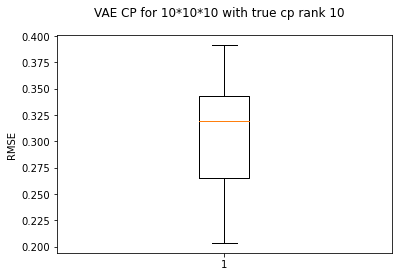

In [75]:
norm10=[]
mse10=[]
for i in testset10:
    data = i.factorMatrices.flatten()
    data = Variable(torch.from_numpy(data).view(1,-1).float().to(device))
    model = model10.to(device)
    x_hat, mu, logvar = model(data)
    x_hat = x_hat[0].cpu().detach().numpy().reshape(3,10,10)
    predictedTensor = cp_compose(i.normalizeFactor,x_hat,10)
    mse10.append(mean_squared_error(predictedTensor.flatten(),i.trueTensor.flatten()))
    norm10.append(np.linalg.norm(predictedTensor-i.trueTensor))
    # print("norm:",np.linalg.norm(predictedTensor-i.trueTensor))
    # print("mse:",mean_squared_error(predictedTensor.flatten(),i.trueTensor.flatten()))

print('total rmse',np.sqrt(sum(mse10)/len(mse10)))
print('median RMSE',np.median(np.sqrt(np.array(mse10))))
print('mean RMSE',np.mean(np.sqrt(np.array(mse10))))
plt.ylabel('RMSE')
plt.suptitle('VAE CP for 10*10*10 with true cp rank 10')
plt.boxplot(np.sqrt(np.array(mse10)))
plt.show()

In [73]:
learning_rate = 0.01
model50 = VariationalAutoencoder50(l1=32,l2=8).to(device)
BCE = nn.BCELoss()
optimizer = torch.optim.Adam(
    model50.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    for data in trainloader50:
        # flattern the data as vector
        # data = np.array([data[0].flatten(),data[1].flatten()])
        data = Variable(data.to(device).float())
        # print(data[0].shape)
        # ===================forward=====================
        x_hat, mu, logvar = model50(data)
        NKLD = mu.pow(2).add(logvar.exp()).mul(-1).add(logvar.add(1))
        KLD = torch.sum(NKLD).mul(-0.5)
        KLD /= batch_size * data[0].shape[0]
        loss = BCE(x_hat, data) + KLD
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================log========================
    print('epoch [{}/{}], loss:{:.4f}'
          .format(epoch + 1, num_epochs, loss.item()))
    if epoch % 10 == 0:
        batch = iter(trainloader50).next()[0]
        batch = batch.view(batch.size(0), -1)
        batch = Variable(batch)
        x_one = batch[0:1]
        x_two = batch[1:2]
torch.save(model50.state_dict(), './sim_variational_autoencoder.pth')

0], loss:-0.1207
epoch [355/1000], loss:-0.1270
epoch [356/1000], loss:-0.1762
epoch [357/1000], loss:-0.0832
epoch [358/1000], loss:-0.0188
epoch [359/1000], loss:-0.0490
epoch [360/1000], loss:-0.0190
epoch [361/1000], loss:-0.0180
epoch [362/1000], loss:-0.0692
epoch [363/1000], loss:-0.2244
epoch [364/1000], loss:-0.1074
epoch [365/1000], loss:0.0085
epoch [366/1000], loss:-0.1258
epoch [367/1000], loss:-0.2692
epoch [368/1000], loss:-0.4771
epoch [369/1000], loss:-0.0963
epoch [370/1000], loss:-0.3985
epoch [371/1000], loss:-0.2875
epoch [372/1000], loss:-0.1116
epoch [373/1000], loss:0.0802
epoch [374/1000], loss:-0.0218
epoch [375/1000], loss:-0.0461
epoch [376/1000], loss:0.0131
epoch [377/1000], loss:0.0394
epoch [378/1000], loss:-0.2462
epoch [379/1000], loss:-0.1436
epoch [380/1000], loss:-0.0015
epoch [381/1000], loss:-0.0991
epoch [382/1000], loss:-0.0085
epoch [383/1000], loss:-0.1953
epoch [384/1000], loss:-0.1320
epoch [385/1000], loss:-0.2649
epoch [386/1000], loss:-0.

total rmse 0.6832648653579503
median RMSE 0.6046854660948431
mean RMSE 0.6534315222934381


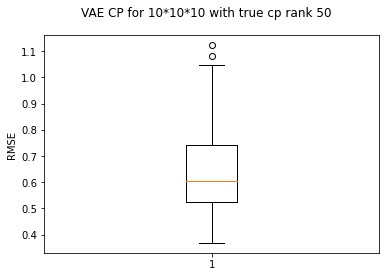

In [74]:
norm50=[]
mse50=[]
for i in testset50:
    data = i.factorMatrices.flatten()
    data = Variable(torch.from_numpy(data).view(1,-1).float().to(device))
    model = model50.to(device)
    x_hat, mu, logvar = model(data)
    x_hat = x_hat[0].cpu().detach().numpy().reshape(3,10,50)
    predictedTensor = cp_compose(i.normalizeFactor,x_hat,50)
    mse50.append(mean_squared_error(predictedTensor.flatten(),i.trueTensor.flatten()))
    norm50.append(np.linalg.norm(predictedTensor-i.trueTensor))
    # print("norm:",np.linalg.norm(predictedTensor-i.trueTensor))
    # print("mse:",mean_squared_error(predictedTensor.flatten(),i.trueTensor.flatten()))

print('total rmse',np.sqrt(sum(mse50)/len(mse50)))
print('median RMSE',np.median(np.sqrt(np.array(mse50))))
print('mean RMSE',np.mean(np.sqrt(np.array(mse50))))
plt.ylabel('RMSE')
plt.suptitle('VAE CP for 10*10*10 with true cp rank 50')
plt.boxplot(np.sqrt(np.array(mse50)))
plt.show()

In [11]:
learning_rate = 0.01
model100 = VariationalAutoencoder100(l1=300,l2=30)
BCE = nn.BCELoss()
# CrossEntropyLoss
optimizer = torch.optim.Adam(
    model100.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    for data in trainloader100:
        # flattern the data as vector
        # data = np.array([data[0].flatten(),data[1].flatten()])
        data = Variable(data.float())
        # print(data[0].shape)
        # ===================forward=====================
        x_hat, mu, logvar = model100(data)
        NKLD = mu.pow(2).add(logvar.exp()).mul(-1).add(logvar.add(1))
        KLD = torch.sum(NKLD).mul(-0.5)
        KLD /= batch_size * data[0].shape[0]
        loss = BCE(x_hat, data) + KLD
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================log========================
    print('epoch [{}/{}], loss:{:.4f}'
          .format(epoch + 1, num_epochs, loss.item()))
    if epoch % 10 == 0:
        batch = iter(trainloader10).next()[0]
        batch = batch.view(batch.size(0), -1)
        batch = Variable(batch)
        x_one = batch[0:1]
        x_two = batch[1:2]
torch.save(model100.state_dict(), './sim_variational_autoencoder.pth')

1000], loss:0.4243
epoch [335/1000], loss:0.3923
epoch [336/1000], loss:0.3808
epoch [337/1000], loss:0.4074
epoch [338/1000], loss:0.3287
epoch [339/1000], loss:0.4172
epoch [340/1000], loss:0.3309
epoch [341/1000], loss:0.3065
epoch [342/1000], loss:0.3663
epoch [343/1000], loss:0.3389
epoch [344/1000], loss:0.2878
epoch [345/1000], loss:0.3385
epoch [346/1000], loss:0.3845
epoch [347/1000], loss:0.3180
epoch [348/1000], loss:0.3587
epoch [349/1000], loss:0.3099
epoch [350/1000], loss:0.3308
epoch [351/1000], loss:0.3573
epoch [352/1000], loss:0.3448
epoch [353/1000], loss:0.4401
epoch [354/1000], loss:0.3167
epoch [355/1000], loss:0.3445
epoch [356/1000], loss:0.3457
epoch [357/1000], loss:0.3739
epoch [358/1000], loss:0.2840
epoch [359/1000], loss:0.3342
epoch [360/1000], loss:0.2624
epoch [361/1000], loss:0.3897
epoch [362/1000], loss:0.3300
epoch [363/1000], loss:0.2781
epoch [364/1000], loss:0.2638
epoch [365/1000], loss:0.3189
epoch [366/1000], loss:0.3219
epoch [367/1000], los

total rmse 14.060684033318882
median RMSE 2.2977928851796663
mean RMSE 5.854869291765539


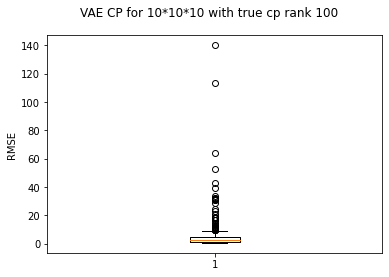

In [12]:
norm100=[]
mse100=[]

for i in testset100:
    data = i.factorMatrices.flatten()
    data = Variable(torch.from_numpy(data).view(1,-1).float())
    x_hat, mu, logvar = model100(data)
    # print(mean_squared_error(cp_compose(i.normalizeFactor,data.reshape(3,10,100),100).flatten(),i.trueTensor.flatten()))
    

    x_hat = x_hat[0].cpu().detach().numpy().reshape(3,10,100)
    predictedTensor = cp_compose(i.normalizeFactor,x_hat,100)
    mse100.append(mean_squared_error(predictedTensor.flatten(),i.trueTensor.flatten()))
    norm100.append(np.linalg.norm(predictedTensor-i.trueTensor))
    # print("norm:",np.linalg.norm(predictedTensor-i.trueTensor))
    # print("mse:",mean_squared_error(predictedTensor.flatten(),i.trueTensor.flatten()))

mse100 =  np.sort(mse100)[:-1]
print('total rmse',np.sqrt(sum(mse100)/len(mse100)))
print('median RMSE',np.median(np.sqrt(np.array(mse100))))
print('mean RMSE',np.mean(np.sqrt(np.array(mse100))))
plt.ylabel('RMSE')
plt.suptitle('VAE CP for 10*10*10 with true cp rank 100')
plt.boxplot(np.sqrt(np.array(mse100)))
plt.show()

In [13]:
dill.dump_session('notebook_env.db')